# Tracking a Point Particle with a CNN

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/1-getting-started/DTGS121_tracking_particle_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeplay deeptrack  # Uncomment if running on Colab/Kaggle.

This tutorial demonstrates how to track a point particle with a convolutional neural network (CNN) using DeepTrack2.

Specifically, this tutotial explains how to: 

- Define the procedure to generate training images.

- Extract information from these images to use as labels for the training.

- Define and train a neural network model.

- Visually evaluate the quality of the neural network output.

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

## 1. Defining the Particle

For this example, you will consider a spherical particle. The light scattering of a spherical particle is described by Mie theory. You will use the `MieSphere` class (see also [scatterers_example](../3-advanced-topics/DTAT321_scatterers.ipynb)), whose properties are controlled by the following parameters:

- `refractive_index`: The refractive index of the particle.

- `radius`: The radius of the particle.

- `position`: The position of the center of the particle.

- `position_unit`: `"pixel"` or `"meter"`.

In [3]:
mie_particle = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=(32, 32),
    position_unit="pixel",
)

## 2. Defining the Optical System 

Next, you need to define the properties of the optical system. This is done using an instance of the `Optics` class (see also [optics_example](../3-advanced-topics/DTAT323_optics.ipynb)), which takes a set of particles (light scatterers) and convolves them with the pupil function (point spread function) of the optical system. In this tutorial, there is only one light scatterer (`mie_particle`).

The optics is controlled by the following parameters:

- `NA`: The numerical aperature.

- `resolution`: The effective camera pixel size (m).

- `magnification`: The magnification of the optical device.

- `wavelength`: The wavelength of the lightsource (m).

- `output_region`: The position of the camera and the number of pixels (x, y, width_x, width_y).

- `upscale`: upscales all calculations. Increases accuracy at the cost of speed.

In [4]:
IMAGE_SIZE = 64

brightfield_microscope = dt.Brightfield(
    NA=0.9,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    upscale=1,
    padding=(32, 32, 32, 32),
)

## 3. Creating and Plotting the Image

To view some object through an optical device, you call the optical device (here, `brightfield_microscope`) with the object you want to image (here, `point_particle`). This creates a new object (here, `imaged_particle`) that can be used to generate the desired image.

The image is finally generated by calling `imaged_particle.resolve()`.

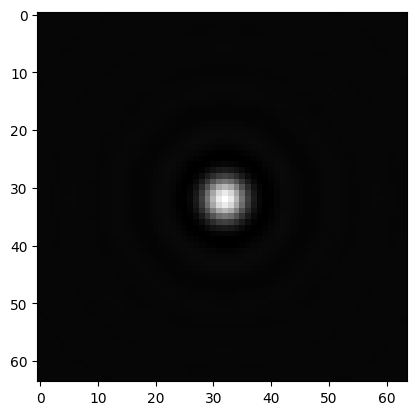

In [5]:
imaged_particle = brightfield_microscope(mie_particle)

output_image = imaged_particle.update().resolve()

plt.imshow(np.squeeze(output_image), cmap="gray")
plt.show()

## 4. Randomizing the Particle Position

You can generate particles with random positions by passing to the keyword argument `position` a lambda function that returns a pair of random numbers representing the particle position. You limit the range of the particle position by asserting that the particle is at least 10 pixels from the edge of the image.

You additionally normalize the image to be between 0 and 1. Often normalizing the neural network input improves the results substantially.

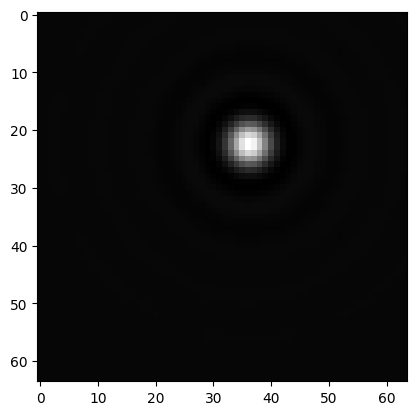

In [6]:
particle_with_random_position = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=lambda: 10 + np.random.rand(2) * (IMAGE_SIZE - 20),
    position_unit="pixel",
)

imaged_particle_with_random_position = \
    brightfield_microscope(particle_with_random_position)

normalized_image_of_particle = \
    imaged_particle_with_random_position >> dt.NormalizeMinMax(0, 1) 

output_image = imaged_particle_with_random_position.update().resolve()

plt.imshow(np.squeeze(output_image), cmap="gray")
plt.show()

The position can then be retrieved from the attribute `.position` of the generated image. The attribute `.properties` contains a list of all properties used to create the image.

Note that to simulate a particle at a new position, you need to call `.update()`.

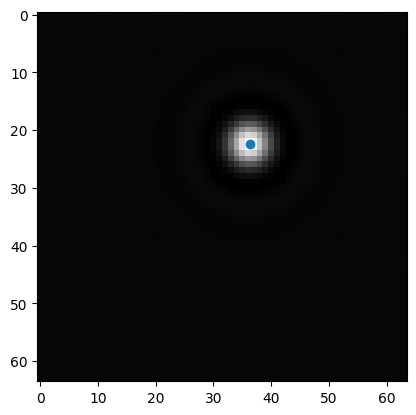

In [7]:
position_of_particle = particle_with_random_position.position()

plt.imshow(np.squeeze(output_image), cmap="gray")
plt.scatter(position_of_particle[1], position_of_particle[0])
plt.show()

## 5. Defining Training Pipeline

You now need to define an image pipeline to generate images of particles and corresponding positions at once.

In [8]:
# Function that retireves the position of a particle and divides it by the
# image size to get values between 0 and 1.
scaled_position_of_particle = \
    particle_with_random_position.position / IMAGE_SIZE

image_and_position_pipeline = \
    imaged_particle_with_random_position & scaled_position_of_particle

## 6. Defining the Neural Network Model

You will use the `deeplay` integration to create a 2D convolutional encoder with a dense top.

The convolutional encoder is defined by the following parameters:

- `in_channels`: The number of input channels.

- `hidden_channels`: The sizes of the hidden layers (list of int).

- `out_channels`: The number of output channels.

The dense top is defined by the following parameters:

- `in_features`: The number of input features (here None, as it is inferred from the encoder).

- `hidden_features`: The sizes of the hidden layers (list of int).

- `out_features`: The number of output features.

You combine the encoder and the dense top together in a `Sequential` model.

In [9]:
import deeptrack.deeplay as dl

conv = dl.ConvolutionalEncoder2d(
    in_channels=1, 
    hidden_channels=[16, 32], 
    out_channels=64
    )

mlp  = dl.MultiLayerPerceptron(
    in_features=None,
    hidden_features=[32],
    out_features=2
    )

net = dl.Sequential(
    conv,
    mlp,
)

print(net)

Sequential(
  (0): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[Identity]()
      )
    )
    (postprocess): Layer[Identity]()
  )
  (1): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[LazyLinear](out_features=32, bias=True)
        (activation): Layer[ReLU]()
      )
      (1): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_fe

## 7. Defining the Regression Application

You now need to define the regression application with the corresponding optimizer and loss function.

In [10]:
model = dl.Regressor(
    net,
    optimizer=dl.Adam(lr=1e-3),
    loss=dl.torch.nn.L1Loss(),
)

print(model)

Regressor(
  (loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.001)
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
          (activation): Layer[ReLU]()
        )
        (1): Conv2dBlock(
          (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
          (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
          (activation): Layer[ReLU]()
        )
        (2): Conv2dBlock(
          (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
          (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
          (activation): Layer[Identity]()
        )
      )
      (postprocess): Lay

## 8. Training the Model

The model is trained by calling the method `.fit()` with the training pipeline you defined in a previous step (which will be used both for training and for validation, as new images are continuously being generated). Be patient, this might take some time (several minutes).

If you are training on a CPU, consider reducing the number of epochs to around 50.

In [11]:

h = model.fit(
    train_data=image_and_position_pipeline,
    val_data=image_and_position_pipeline,  
    max_epochs=100,
    batch_size=32,
    steps_per_epoch=100,
    val_batch_size=256,
    val_steps_per_epoch=1,
)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ Sequential       │ 23.4 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 23.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 23.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

You can now plot the training history.

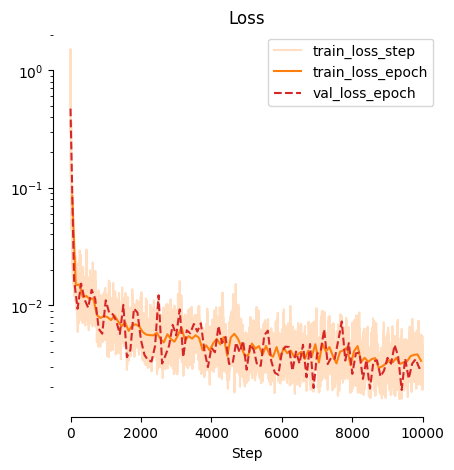

In [12]:
import seaborn as sns

keys = list(h.history.keys())
keys = [key.replace("val", "").replace("train", "") for key in keys]
keys = list(set(keys))

history = h.history
step_history = h.step_history

max_width = 3
rows = len(keys) // max_width + 1
width = min(len(keys), max_width)

fig, axes = plt.subplots(rows, width, figsize=(5 * width, 5 * rows))

if len(keys) == 1:
    axes = np.array([[axes]])

for ax, key in zip(axes.ravel(), keys):
    train_key = "train" + key
    val_key = "val" + key
    step_key = ("train" + key).replace("epoch", "step")

    
    if step_key in step_history:
        ax.plot(step_history[step_key]["step"],
                step_history[step_key]["value"],
                label=step_key, color="C1", alpha=0.25)

    if train_key in history:
        step = np.array(history[train_key]["step"])
        step[1:] = step[1:] - (step[1:] - step[:-1]) / 2
        step[0] /= 2
        ax.plot(step, history[train_key]["value"], label=train_key, color="C1")

    if val_key in history:
        ax.plot(history[val_key]["step"],
                history[val_key]["value"],
                label=val_key, color="C3", linestyle="--")
    
    ax.set_title(key.replace("_", " ").replace("epoch", "") \
                 .strip().capitalize())
    ax.set_xlabel("Step")

    ax.legend()
    ax.set_yscale("log")
    sns.despine(ax=ax, trim=True)

## 9. Visualizing the Model Performance

You can now use the trained model to measure the particle position in images previously unseen by the model.

For real applications, it should be noted that the performance can be improved significantly by constraining the particle to be close to the center.

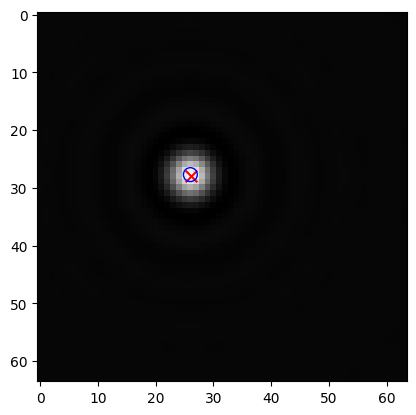

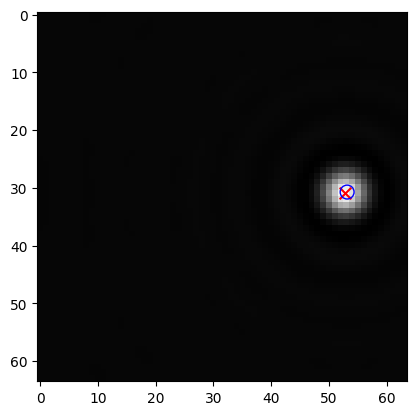

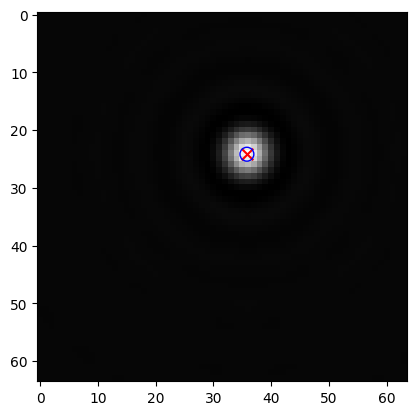

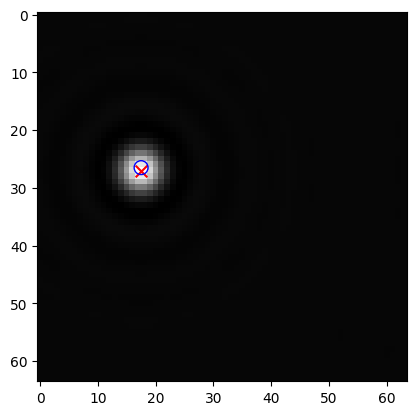

In [13]:
for i in range(4):

    image, true_position = image_and_position_pipeline.update().resolve()
    measured_position = model.predict(np.transpose(image[None], (0,3,1,2)))
    measured_position_x = measured_position[0, 1] * IMAGE_SIZE
    measured_position_y = measured_position[0, 0] * IMAGE_SIZE

    real_position_x = true_position[1] * IMAGE_SIZE
    real_position_y = true_position[0] * IMAGE_SIZE

    plt.imshow(image, cmap="gray")
    plt.scatter(real_position_x,
                real_position_y, s=70, c="r", marker="x")
    plt.scatter(measured_position_x,
                measured_position_y,
                s=100, marker="o", facecolor="none", edgecolors="b")
    plt.show()